Want to find out how much randomness plays a factor in a given person's position. It seems random that people end up in different posiitons despite having the same number of points. Is this just luck or ar they getting points when others aren't?

In [1]:
from fpl import FPL
from collections import defaultdict
import aiohttp
import asyncio
import json
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter

person2id = {
    "Me": 2829211,
    "Brah": 3354213,
    "Bob":2418979,
    "TT": 2611294,
    "Richie": 2230444,
    "Mikey": 4515703,
    "Sully": 4188610,
    "Space": 2613455,
    "Ck": 988851,
    "Byrno": 3382921,
    "Cusack": 1181142,
    "Duffman": 5012241,
}

person2idx = {
    "Me": 0,
    "Brah": 1,
    "Bob":2,
    "TT": 3,
    "Richie": 4,
    "Mikey": 5,
    "Sully": 6,
    "Space": 7,
    "Ck": 8,
    "Byrno": 9,
    "Cusack": 10,
    "Duffman": 11,
}

idx2person = {v: k for k, v in person2idx.items()}

In [2]:
async def main(user_id, name):
    async with aiohttp.ClientSession() as session:
        fpl = FPL(session)
        user = await fpl.get_user(user_id)
        thing = await user.get_gameweek_history()
        
    json_string = json.dumps(thing)
    with open('json_data_{}.json'.format(name), 'w') as outfile:
        json.dump(json_string, outfile)
    

In [3]:
# get user data
for name in person2id:
    await main(person2id[name], name)
    
# get league info
league_data = defaultdict()
for name in person2id:
    with open('json_data_{}.json'.format(name)) as json_file:
        data = json.load(json_file)
        datas = json.loads(data)
        league_data[name] = datas

# get stats
plt.figure(figsize=(10, 8))
gw_data = defaultdict(list)
sum_data = defaultdict(list)
for name in person2id:
    for gw in league_data[name]:
        gw_data[name].append(gw['points'])
        sum_data[name].append(sum(gw_data[name]))


<Figure size 720x576 with 0 Axes>

get rankings for each gameweek which will be used to ascribe points for hypothetical schedules


In [4]:
name2rank = defaultdict(list)
for gw_idx in range(0, len(gw_data['Me'])):
    gw_points = []
    for name in gw_data:
        gw_points.append(gw_data[name][gw_idx])
    ranked = rankdata(gw_points, method='min')
    for idx, rank in enumerate(ranked):
        name2rank[idx2person[idx]].append(rank)


In [5]:
# NOTE: Taken from https://gist.github.com/mikeyakymenko/bd066307c26f41104c43664cb8c37297
def create_round_robin(players):
    """ Create a schedule for the players in the list and return it"""
    s = []
    random.shuffle(players)
    n = len(players)
    map = list(range(n))
    mid = n // 2
    
    for i in range(n-1):
        l1 = map[:mid]
        l2 = map[mid:]
        l2.reverse()
        round = []
        for j in range(mid):
            t1 = players[l1[j]]
            t2 = players[l2[j]]
            if j == 0 and i % 2 == 1:
                # flip the first match only, every other round
                # (this is because the first match always involves the last player in the list)
                round.append((t2, t1))
            else:
                round.append((t1, t2))
        s.append(round)
        # rotate list by n/2, leaving last element at the end
        map = map[mid:-1] + map[:mid] + map[-1:]
    return s
    


In [6]:
# run n number of leagues with different schedules
number_of_runs = 100000
name2sim_values = defaultdict(list)
name2league_rank = defaultdict(list)
for i in range(0, number_of_runs):
    teams = list(person2idx.keys())
    # need two independent schedules since league doesn't have round robin number of games
    # since there are 20 pl teams, x number of fpl players within the league.
    schedule_1 = create_round_robin(teams)
    schedule_2 = create_round_robin(teams)
    hypothetical_league_sum = defaultdict(int)
    for gameweek_idx in range(0, len(gw_data['Me'])):
        # here handle the distinct schedules, mod the num of teams into num of pl games
        if gameweek_idx<38-38%(len(name2rank)-1):
            hypothetical_week =  schedule_1[gameweek_idx%(len(name2rank)-1)]
            for match in hypothetical_week:
                if name2rank[match[0]][gameweek_idx]>name2rank[match[1]][gameweek_idx]:
                    hypothetical_league_sum[match[0]]+=3
                elif name2rank[match[0]][gameweek_idx]<name2rank[match[1]][gameweek_idx]:
                    hypothetical_league_sum[match[1]]+=3
                else:
                    hypothetical_league_sum[match[0]]+=1
                    hypothetical_league_sum[match[1]]+=1
        else:
            hypothetical_week =  schedule_2[gameweek_idx%(len(name2rank)-1)]
            for match in hypothetical_week:
                if name2rank[match[0]][gameweek_idx]>name2rank[match[1]][gameweek_idx]:
                    hypothetical_league_sum[match[0]]+=3
                elif name2rank[match[0]][gameweek_idx]<name2rank[match[1]][gameweek_idx]:
                    hypothetical_league_sum[match[1]]+=3
                else:
                    hypothetical_league_sum[match[0]]+=1
                    hypothetical_league_sum[match[1]]+=1
        # need value of league sums ordered so indices match with names
    sum2position = []
    for idx in idx2person:
        sum2position.append(hypothetical_league_sum[idx2person[idx]])
    
    league_rank = rankdata(sum2position, method='min')
    for idx, rank in enumerate(league_rank):
        name2league_rank[idx2person[idx]].append(rank)
        
    for name in hypothetical_league_sum:
        name2sim_values[name].append(hypothetical_league_sum[name])
    
    

In [7]:
rank2pos = {
    12: "First",
    11: "Second",
    10: "Third",
    9: "Fourth",
    8: "Fifth",
    7: "Sixth",
    6: "Seventh",
    5: "Eigth",
    4: "Ninth",
    3: "Tenth",
    2: "Second last",
    1: "Tragic",

}
# now get the probability you should have a given position simulated across presumably every possible schedule
name2probabilities = defaultdict(list)
for name in name2sim_values:
    rank_counter = Counter(name2league_rank[name])
    for potential_rank in rank2pos:
        name2probabilities[name].append(rank_counter[potential_rank]/number_of_runs)
        

Make a pretty plot

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]),
 <a list of 11 Text major ticklabel objects>)

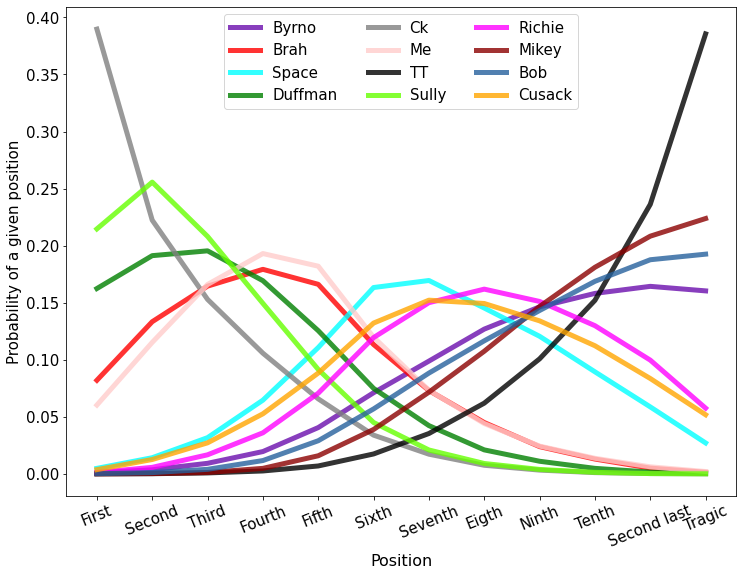

In [8]:
name2col = {
    "Ck": "#808080",
    "Me": "#ffcccb",
    "Brah": "r",
    "Byrno": "#6a0dad",
    "Mikey": "#8b0000",
    "Bob": "#26619c",
    "Sully": "#66ff00",
    "Space": "cyan",
    "Cusack": "#FFA500",
    "TT": "k",
    "Richie": "fuchsia",
    "Duffman": "g",

}
plt.figure(figsize=(12, 9))
for name in name2probabilities:
    plt.plot(name2probabilities[name], '-', label=name, lw=5, alpha=0.8, color=name2col[name])
plt.legend(fontsize=15, ncol=3)
plt.ylabel("Probability of a given position", fontsize=15)
plt.xlabel("Position", fontsize=16)
plt.xticks(np.arange(0, 12), list(rank2pos.values()), fontsize=15, rotation=22)
plt.yticks(fontsize=15)
#plt.savefig("proba_fpl.pdf")

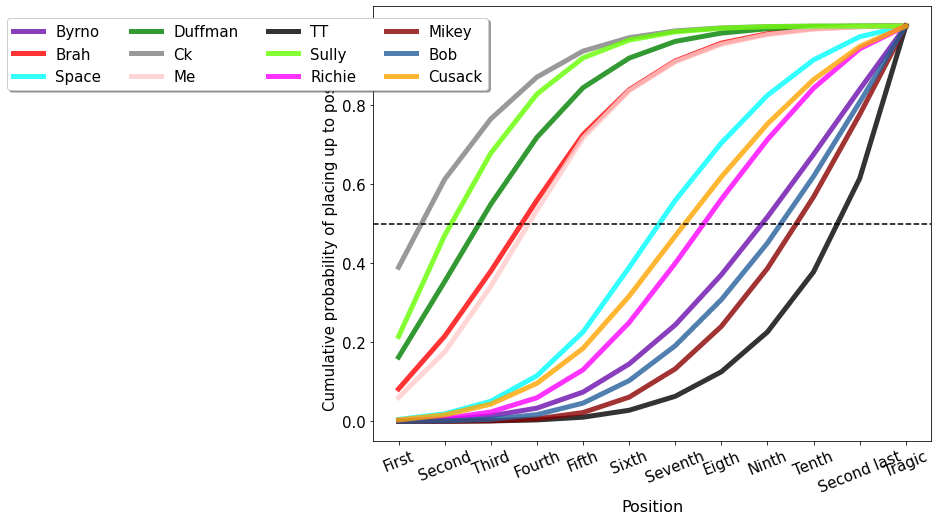

In [9]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
cumulative_probs = defaultdict(list)
for name in name2probabilities:
    for i in range(1, 13):
        cumulative_probs[name].append(sum(name2probabilities[name][:i]))
for name in cumulative_probs:
    plt.plot(cumulative_probs[name], '-', label=name, lw=5, alpha=0.8, color=name2col[name])
        #plt.plot(i, sum(name2probabilities[name][:i]), 'o',label=name, lw=5, alpha=0.8, color=name2col[name])
plt.ylabel("Cumulative probability of placing up to position x", fontsize=15)
plt.xlabel("Position", fontsize=16)
plt.xticks(np.arange(0, 12), ["{}".format(x) for x in list(rank2pos.values())], fontsize=15, rotation=22)
plt.yticks(fontsize=15)
plt.axhline(0.5, color='k', linestyle='--')
ax.legend(fontsize=15, bbox_to_anchor=(0.22, 0.99), ncol=4, loc='best', fancybox=True, shadow=True)
plt.savefig("cum_sum.pdf")


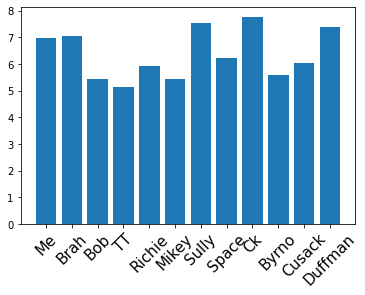

Text(0, 0.5, 'Total points')

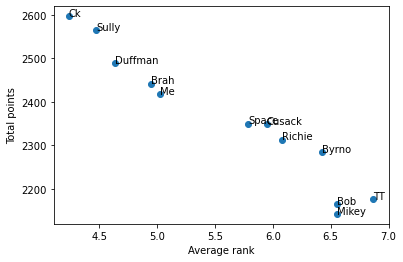

In [10]:
avg_ranks = []
sums = []
for name in name2rank:
    avg_ranks.append(np.mean(name2rank[name]))
    sums.append(sum_data[name][-1])

plt.bar(np.arange(0, len(name2rank)),avg_ranks)
plt.xticks(np.arange(0, 12), list(name2rank.keys()), fontsize=15, rotation=45)
plt.show()

plt.plot(12-np.array(avg_ranks), sums, 'o')
for name in name2rank:
    plt.text(12-np.mean(name2rank[name]), sum_data[name][-1], name)
plt.xlabel("Average rank")
plt.ylabel("Total points")
#plt.savefig("comparison.pdf")

This model assumes that each player's behaviour is independent of the schedule, and who they might play next. Therefore, what this cannot test for is whether people's behaviour changes depending on who they are playing, which would presumably move the needle this way or that in some cases, but people could be biased in believing that.